# EEG Analysis

In this notebook, we will analyze an EEG dataset, the [MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the [ChildMind Institute](https://childmind.org).

Note that the pre-processing of the data as available in the dataset, doing data cleaning and calculating power spectra, is done external to this project. The resultant power spectra from this process are available in the `data` folder. 

In this analysis, we will process the power spectra, calculating band ratio measures and parameterizing spectral features, and examine their inter-relations.

In [1]:
%matplotlib inline

import csv

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('talk')

import mne

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from bootstrap import bootstrap_corr, bootstrap_diff
from utils import print_stat, print_stats, print_ap_corrs
from analysis import (get_all_data, nan_corr_spearman, average_df,
                      param_corr, param_ratio_corr,
                      param_ratio_boot_corr, param_ratio_diff_corr)
from plot import plot_param_ratio_corr, plot_param_ratio_corr_exp

from settings import BAND_NAMES, RATIO_NAMES, FEATURE_LABELS
from paths import DATA_PATHS as dp

In [3]:
# Settings
SAVE_FIG = False
PROCESS_DATA = False   # If False, reload previously processed & saved data
SHOW_SUB = False       # Whether to display correlation plots for channel sub-selections
SHOW_EXP = False       # Whether to display plots for the aperiodic exponent correlation

In [4]:
# Set random seed
np.random.seed(53)

## Import Data

Here we import power spectra and select channel clusters from the EEG montage that was used.

In [5]:
# Read datafile with dataset information
data = pd.read_csv(dp.make_file_path(dp.eeg_meta, 'MIPDB_PublicFile', 'csv'))

In [6]:
# Read in list of channel names that are kept in reduced 111 montage
with open(dp.make_file_path(dp.eeg_meta, 'chans111', 'csv'), 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]

In [7]:
# Read channel montage
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

In [8]:
# Get the list of all channels
all_chans = mne.pick_channels(montage.ch_names, ch_labels)

In [9]:
# Define channel clusters of interest
ch_cluster_frontal = ['E15', 'E18', 'E16', 'E10', 'E11']
ch_cluster_central = ['E7','E106', 'E31', 'Cz', 'E80']
ch_cluster_parietal = ['E71', 'E76', 'E70', 'E75', 'E83']

# Get the indices of the channels of interest
ch_inds_frontal = mne.pick_channels(montage.ch_names, ch_cluster_frontal)
ch_inds_central = mne.pick_channels(montage.ch_names, ch_cluster_central)
ch_inds_parietal = mne.pick_channels(montage.ch_names, ch_cluster_parietal)

In [10]:
# Get a list of all channels of interest
ch_interest = ch_cluster_frontal + ch_cluster_central + ch_cluster_parietal
montage.selection = ch_interest

# Correlation between Spectral Parameters and Ratio Measures

Below we run our data through a process which returns a dataframe where each row is a specific channel from a subject. 

Columns include spectral parameters for alpha, beta, and theta oscillations as well as theta/beta ratio, theta/alpha ratio, and alpha/beta ratio.

In [11]:
# Create the dataframe of all the data
if PROCESS_DATA:
    
    # Load and process the data
    df = get_all_data(data, all_chans)
    
    # Save out the contructed dataframe
    df.to_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'),
              index=False)

else:
    # Reload the dataframe
    df = pd.read_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'))

The above process creates a dataframe which each measure calculated and extracted for each subject, each channel.

In [12]:
# Check out the created dataframe
df.head()

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW,fit_error,fit_n_peaks,fit_r2
0,7.813890,10.0,2.576703,10.435449,0.632868,1.000000,21.527198,0.400035,0.0,1.861029,1.198543,A00051826,1.910381,14.927507,2.465467,7.168887,0.620085,0.059703,6.0,0.985572
1,6.434886,10.0,2.486382,10.419302,0.437829,1.000000,21.621280,0.398605,1.0,1.921815,1.667305,A00051826,2.560303,16.475258,2.423633,7.288577,0.636508,0.075356,5.0,0.981487
2,7.159705,10.0,3.150005,10.162052,0.562540,1.561147,23.902277,0.436887,2.0,1.928513,1.440073,A00051826,2.345069,16.790004,1.000000,7.672382,0.571536,0.062042,8.0,0.986960
3,7.314351,10.0,3.084685,10.129066,0.540991,1.116479,23.754142,0.321803,3.0,1.994314,1.536313,A00051826,2.292491,16.768082,1.291792,6.405548,0.463999,0.060083,8.0,0.987369
4,8.363157,10.0,2.832392,10.198237,0.541733,1.000000,23.822393,0.201616,4.0,2.005431,1.579849,A00051826,2.600753,21.750502,1.621394,6.952035,0.554800,0.071300,5.0,0.984456


Now, we can use the function `param_ratio_corr()` to find the correlations between a ratio measure and all spectral parameters.

We can now do that, stepping through each ratio measure, and sub-selecting different channel clusters, as we wish. 

In the subsequent analyses, we will display the correlation matrices for the global results (across all channels). 

We also calculate and save out figure for each channel cluster, which are saved and available in the `figures` folder.

## Theta Beta Ratio (TBR)

Compare the theta / beta ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [13]:
# Calculate the correlation between ratios and spectral features
tbr_pe_rs, tbr_ap_rs, tbr_pe_cis, tbr_ap_cis, tbr_pe_ps, tbr_ap_ps = \
    param_ratio_boot_corr(df, "TBR", all_chans, corr_func=nan_corr_spearman)

In [14]:
# Print out statistics for the TBR
print_stats(tbr_pe_rs, tbr_pe_cis, tbr_pe_ps, BAND_NAMES, FEATURE_LABELS)

Theta
	 CF 	 -0.0040    [-0.2004, +0.1912]    0.9676
	 PW 	 +0.3439    [+0.1492, +0.5183]    0.0003
	 BW 	 +0.3137    [+0.1158, +0.4907]    0.0009
Alpha
	 CF 	 -0.4181    [-0.5569, -0.2533]    0.0000
	 PW 	 -0.0246    [-0.2133, +0.1671]    0.7978
	 BW 	 +0.0190    [-0.1779, +0.2156]    0.8434
Beta
	 CF 	 -0.0718    [-0.2648, +0.1263]    0.4537
	 PW 	 -0.2841    [-0.4581, -0.0869]    0.0025
	 BW 	 -0.0790    [-0.2680, +0.1129]    0.4101


In [15]:
# Print out results of correlates between ratio and aperiodic & demographic features
print_ap_corrs("TBR", tbr_ap_rs, tbr_ap_cis, tbr_ap_ps)

Corr of TBR to Exp:    +0.7661    [+0.6572, +0.8427]    0.0000
Corr of TBR to Off:    +0.7560    [+0.6508, +0.8316]    0.0000
Corr of TBR to Age:    -0.6665    [-0.7579, -0.5435]    0.0000


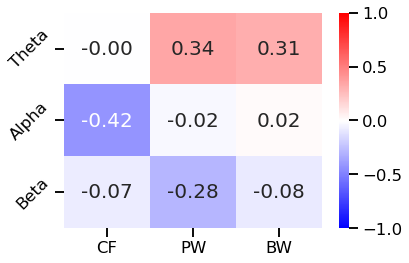

In [16]:
# Plot the correlation matrix of the ratio measure and spectral features
plot_param_ratio_corr(tbr_pe_rs, show=True,
                      save_fig=SAVE_FIG, file_name="Global_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_rs, show=SHOW_EXP,
                          save_fig=SAVE_FIG, file_name="Global_TBR_corrs")

In [17]:
# Compare difference of correlations
print('Differences of correlations (TBR):')
print_stat('Theta PW vs. Beta PW', 
           *param_ratio_diff_corr(df, "TBR", "Theta_PW", "Beta_PW",
                                  all_chans, absolute=True,
                                  corr_func=nan_corr_spearman))

print_stat('AP-Exp   vs. Theta PW', 
           *param_ratio_diff_corr(df, "TBR", "Exp", "Theta_PW",
                                  all_chans, absolute=True, 
                                  corr_func=nan_corr_spearman))

print_stat('AP-Exp   vs. Beta PW',
           *param_ratio_diff_corr(df, "TBR", "Exp", "Beta_PW",
                                  all_chans, absolute=True,
                                  corr_func=nan_corr_spearman))

Differences of correlations (TBR):
	 Theta PW vs. Beta PW 	 +0.0598    [-0.2567, +0.3585]    0.6972
	 AP-Exp   vs. Theta PW 	 +0.4222    [+0.2240, +0.6299]    0.0000
	 AP-Exp   vs. Beta PW 	 +0.4820    [+0.2623, +0.6928]    0.0004


### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are available in `figures`.

In [18]:
# Frontal Channels
tbr_pe_fr, tbr_ap_fr, _, _ = param_ratio_corr(df, "TBR", ch_inds_frontal, func=nan_corr_spearman)
print_ap_corrs("TBR", tbr_ap_fr, show=SHOW_SUB)

plot_param_ratio_corr(tbr_pe_fr, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Frontal_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_fr, show=False,
                          save_fig=SAVE_FIG, file_name="Frontal_TBR_corrs")

In [19]:
# Central channels
tbr_pe_ce, tbr_ap_ce, _, _ = param_ratio_corr(df, "TBR", ch_inds_central, func=nan_corr_spearman)
print_ap_corrs("TBR", tbr_ap_ce, show=SHOW_SUB)

plot_param_ratio_corr(tbr_pe_ce, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Central_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_ce, show=False,
                          save_fig=SAVE_FIG, file_name="Central_TBR_corrs")

In [20]:
# Parietal channels
tbr_pe_pa, tbr_ap_pa, _, _ = param_ratio_corr(df, "TBR", ch_inds_parietal, func=nan_corr_spearman)
print_ap_corrs("TBR", tbr_ap_pa, show=SHOW_SUB)

plot_param_ratio_corr(tbr_pe_pa, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Parietal_TBR_corrs")
plot_param_ratio_corr_exp(tbr_ap_pa, show=False,
                          save_fig=SAVE_FIG, file_name="Parietal_TBR_corrs")

## TAR: Theta Alpha Ratio

Compare the theta / alpha ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [21]:
# Calculate the correlation between ratios and spectral features
tar_pe_rs, tar_ap_rs, tar_pe_cis, tar_ap_cis, tar_pe_ps, tar_ap_ps = \
    param_ratio_boot_corr(df, "TAR", all_chans, corr_func=nan_corr_spearman)

In [22]:
# Print out statistics for the TAR
print_stats(tar_pe_rs, tar_pe_cis, tar_pe_ps, BAND_NAMES, FEATURE_LABELS)

Theta
	 CF 	 -0.3343    [-0.4870, -0.1633]    0.0004
	 PW 	 -0.2049    [-0.3878, -0.0070]    0.0334
	 BW 	 +0.2069    [+0.0128, +0.3811]    0.0317
Alpha
	 CF 	 -0.0826    [-0.2685, +0.1093]    0.3890
	 PW 	 -0.8934    [-0.9285, -0.8384]    0.0000
	 BW 	 -0.1764    [-0.3532, +0.0109]    0.0641
Beta
	 CF 	 +0.2152    [+0.0312, +0.3896]    0.0233
	 PW 	 -0.3993    [-0.5679, -0.2173]    0.0000
	 BW 	 -0.3164    [-0.4872, -0.1371]    0.0007


In [23]:
# Print out results of correlates between ratio and aperiodic & demographic features
print_ap_corrs("TAR", tar_ap_rs, tar_ap_cis, tar_ap_ps)

Corr of TAR to Exp:    +0.2635    [+0.0867, +0.4262]    0.0052
Corr of TAR to Off:    +0.2645    [+0.0730, +0.4338]    0.0050
Corr of TAR to Age:    -0.3688    [-0.5223, -0.2028]    0.0001


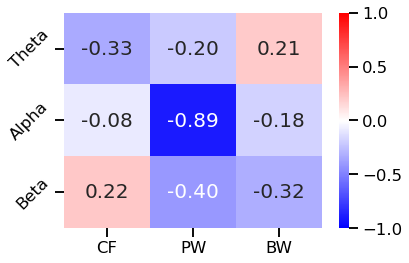

In [24]:
# Plot the correlation matrix of the ratio measure and spectral features
plot_param_ratio_corr(tar_pe_rs, show=True,
                      save_fig=SAVE_FIG, file_name="Global_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_rs, show=SHOW_EXP,
                          save_fig=SAVE_FIG, file_name="Global_TAR_corrs")

In [25]:
# Compare difference of correlations
print('Differences of correlations (TAR):')
print_stat('Alpha PW vs. AP-EXP', 
           *param_ratio_diff_corr(df, "TAR", "Alpha_PW", "Exp",
                                  all_chans, absolute=True,
                                  corr_func=nan_corr_spearman))

Differences of correlations (TAR):
	 Alpha PW vs. AP-EXP 	 +0.6298    [+0.4510, +0.8176]    0.0000


### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are available in `figures`.

In [26]:
# Frontal Channels
tar_pe_fr, tar_ap_fr, _, _ = param_ratio_corr(df, "TAR", ch_inds_frontal, func=nan_corr_spearman)
print_ap_corrs("TAR", tar_ap_fr, show=SHOW_SUB)

plot_param_ratio_corr(tar_pe_fr, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Frontal_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_fr, show=False,
                          save_fig=SAVE_FIG, file_name="Frontal_TAR_corrs")

In [27]:
# Central Channels
tar_pe_ce, tar_ap_ce, _, _ = param_ratio_corr(df, "TAR", ch_inds_central, func=nan_corr_spearman)
print_ap_corrs("TAR", tar_ap_ce, show=SHOW_SUB)

plot_param_ratio_corr(tar_pe_ce, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Central_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_ce, show=False,
                          save_fig=SAVE_FIG, file_name="Central_TAR_corrs")

In [28]:
# Parietal Channels
tar_pe_pa, tar_ap_pa, _, _ = param_ratio_corr(df, "TAR", ch_inds_parietal, func=nan_corr_spearman)
print_ap_corrs("TAR", tar_ap_pa, show=SHOW_SUB)

plot_param_ratio_corr(tar_pe_pa, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Parietal_TAR_corrs")
plot_param_ratio_corr_exp(tar_ap_pa, show=False,
                          save_fig=SAVE_FIG, file_name="Parietal_TAR_corrs")

## Alpha Beta Ratio (ABR)

Compare the alpha / beta ratio to spectral parameters.

### Global

Calculate the relationship between ratio measure and spectral features, across all channels.

In [29]:
# Calculate the correlation between ratios and spectral features
abr_pe_rs, abr_ap_rs, abr_pe_cis, abr_ap_cis, abr_pe_ps, abr_ap_ps = \
    param_ratio_boot_corr(df, "ABR", all_chans, corr_func=nan_corr_spearman)

In [30]:
# Print out statistics for the ABR
print_stats(abr_pe_rs, abr_pe_cis, abr_pe_ps, BAND_NAMES, FEATURE_LABELS)

Theta
	 CF 	 +0.3067    [+0.1261, +0.4665]    0.0012
	 PW 	 +0.4508    [+0.2960, +0.5834]    0.0000
	 BW 	 +0.0186    [-0.1752, +0.2162]    0.8481
Alpha
	 CF 	 -0.2348    [-0.4045, -0.0428]    0.0131
	 PW 	 +0.8685    [+0.7874, +0.9194]    0.0000
	 BW 	 +0.1368    [-0.0623, +0.3244]    0.1522
Beta
	 CF 	 -0.1995    [-0.3844, -0.0088]    0.0358
	 PW 	 +0.1957    [+0.0145, +0.3699]    0.0396
	 BW 	 +0.2642    [+0.0778, +0.4339]    0.0051


In [31]:
# Print out results of correlates between ratio and aperiodic & demographic features
print_ap_corrs("ABR", abr_ap_rs, abr_ap_cis, abr_ap_ps)

Corr of ABR to Exp:    +0.3246    [+0.1338, +0.4878]    0.0005
Corr of ABR to Off:    +0.2974    [+0.1010, +0.4719]    0.0015
Corr of ABR to Age:    -0.1163    [-0.2924, +0.0654]    0.2242


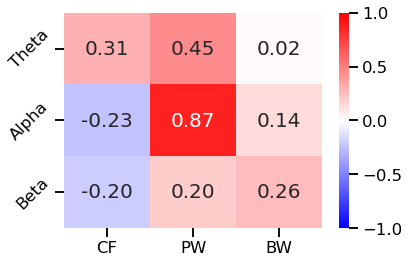

In [32]:
# Plot the correlation matrix of the ratio measure and spectral features
plot_param_ratio_corr(abr_pe_rs, show=True,
                      save_fig=SAVE_FIG, file_name="Global_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_rs, show=SHOW_EXP,
                          save_fig=SAVE_FIG, file_name="Global_ABR_corrs")

In [33]:
# Compare difference of correlations
print('Differences of correlations (ABR):')
print_stat('Alpha PW vs. AP-EXP', 
           *param_ratio_diff_corr(df, "ABR", "Alpha_PW", "Exp",
                                  all_chans, absolute=True,
                                  corr_func=nan_corr_spearman))

Differences of correlations (ABR):
	 Alpha PW vs. AP-EXP 	 +0.5439    [+0.3482, +0.7433]    0.0000


### Channel Sub-Selections

The next set of cells calculates the same measures on channel sub-selections.

By default, these plots are not displayed, but are available in `figures`.

In [34]:
# Frontal Channels
abr_pe_fr, abr_ap_fr, _, _ = param_ratio_corr(df, "ABR", ch_inds_frontal, func=nan_corr_spearman)
print_ap_corrs("ABR", abr_ap_fr, show=SHOW_SUB)

plot_param_ratio_corr(abr_pe_fr, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Frontal_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_fr, show=False,
                          save_fig=SAVE_FIG, file_name="Frontal_ABR_corrs")

In [35]:
# Central Channels
abr_pe_ce, abr_ap_ce, _, _ = param_ratio_corr(df, "ABR", ch_inds_central, func=nan_corr_spearman)
print_ap_corrs("ABR", abr_ap_ce, show=SHOW_SUB)

plot_param_ratio_corr(abr_pe_ce, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Central_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_ce, show=False,
                          save_fig=SAVE_FIG, file_name="Central_ABR_corrs")

In [36]:
# Parietal Channels
abr_pe_pa, abr_ap_pa, _, _ = param_ratio_corr(df, "ABR", ch_inds_parietal, func=nan_corr_spearman)
print_ap_corrs("ABR", abr_ap_pa, show=SHOW_SUB)

plot_param_ratio_corr(abr_pe_pa, show=SHOW_SUB,
                      save_fig=SAVE_FIG, file_name="Parietal_ABR_corrs")
plot_param_ratio_corr_exp(abr_ap_pa, show=False,
                          save_fig=SAVE_FIG, file_name="Parietal_ABR_corrs")

## Correlations between Age and Aperiodic Exponent

Calculate the correlation of aperiodic exponent to age.

In [37]:
# Check correlation across all channels
age_exp_corr, age_exp_cis, age_exp_p = param_corr(df, "Age", "Exp", all_chans, bootstrap_corr)
print_stat('Age-EXP corr  global: ', age_exp_corr, age_exp_cis, age_exp_p)

	 Age-EXP corr  global:  	 -0.6807    [-0.7694, -0.5642]    0.0000


In [38]:
# Check correlation of age and exponent within channel sub-selections
print_stat('Age-EXP corr  frontal: ',
           *param_corr(df, "Age", "Exp", ch_inds_frontal, bootstrap_corr))
print_stat('Age-EXP corr  central: ', 
           *param_corr(df, "Age", "Exp", ch_inds_central, bootstrap_corr)) 
print_stat('Age-EXP corr  parietal: ', 
           *param_corr(df, "Age", "Exp", ch_inds_parietal, bootstrap_corr))

	 Age-EXP corr  frontal:  	 -0.7032    [-0.7877, -0.5989]    0.0000
	 Age-EXP corr  central:  	 -0.6281    [-0.7403, -0.4932]    0.0000
	 Age-EXP corr  parietal:  	 -0.7101    [-0.7829, -0.6108]    0.0000


### Compare Age Correlations

In [39]:
# Compare ratio correlations with age, vs exponent
for ratio in ["TBR", "TAR", "ABR"]:
    print_stat('Age: {} vs EXP'.format(ratio), 
               *bootstrap_diff(df["Age"].values, df["Exp"].values, df[ratio].values))

	 Age: TBR vs EXP 	 -0.0066    [-0.0161, +0.0030]    0.1796
	 Age: TAR vs EXP 	 -0.2868    [-0.3050, -0.2684]    0.0000
	 Age: ABR vs EXP 	 -0.5074    [-0.5258, -0.4892]    0.0000


In [40]:
# Compare ratios to each other, and their relation to age
for ratio1 in ["TBR", "TAR", "ABR"]:
    for ratio2 in ["TAR", "ABR"]:
        if ratio1 == ratio2: continue
        print_stat('Age: {} vs {}'.format(ratio1, ratio2), 
               *bootstrap_diff(df["Age"].values, df[ratio1].values, df[ratio2].values))

	 Age: TBR vs TAR 	 -0.2803    [-0.2980, -0.2628]    0.0000
	 Age: TBR vs ABR 	 -0.5008    [-0.5187, -0.4833]    0.0000
	 Age: TAR vs ABR 	 -0.2205    [-0.2520, -0.1895]    0.0000
	 Age: ABR vs TAR 	 +0.2205    [+0.1887, +0.2504]    0.0000


We can also consider the possibility of updated ratio measures, that compute the ratio of parameterized band powers. 

To briefly examine such measures, we will calculate 'parameterized ratios', and compare them to age.

In [41]:
# Calculate parameterized ratios
avg_df = average_df(df, all_chans)
param_tbr = avg_df["Theta_PW"].values / avg_df["Beta_PW"].values
param_tar = avg_df["Theta_PW"].values / avg_df["Alpha_PW"].values
param_abr = avg_df["Alpha_PW"].values / avg_df["Beta_PW"].values

In [42]:
# Compare Correlations of Parameterized Ratios with Age
print_stat('P-TBR & Age:', *bootstrap_corr(
    avg_df["Age"].values, param_tbr, func=nan_corr_spearman))
print_stat('P-TAR & Age:', *bootstrap_corr(
    avg_df["Age"].values, param_tar, func=nan_corr_spearman))
print_stat('P-ABR & Age:', *bootstrap_corr(
    avg_df["Age"].values, param_abr, func=nan_corr_spearman))

	 P-TBR & Age: 	 -0.1221    [-0.2942, +0.0525]    0.2080
	 P-TAR & Age: 	 -0.1314    [-0.3073, +0.0508]    0.1752
	 P-ABR & Age: 	 -0.0848    [-0.2728, +0.1063]    0.3760
